In [134]:
# main packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statistical packages for time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf

# split and scaler packages
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.utils.class_weight import compute_class_weight

# models
from sklearn.ensemble import IsolationForest
from keras.models import Model, Sequential
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input


## Exploratory Data Analysis

In [7]:
# exploratory data analysis - normal dataset
data_normal = pd.read_csv("data/ptbdb_normal.csv")
print(data_normal.shape)
data_normal.head()

(4045, 188)


,1.000000000000000000e+00,9.003241658210754395e-01,3.585899472236633301e-01,5.145867168903350830e-02,4.659643396735191345e-02,1.268233358860015869e-01,1.333063244819641113e-01,1.191247999668121338e-01,1.106158867478370667e-01,1.130470037460327148e-01,1.065640226006507874e-01,1.069692075252532959e-01,1.158833056688308716e-01,1.223662868142127991e-01,1.223662868142127991e-01.1,1.195299848914146423e-01,1.158833056688308716e-01.1,1.223662868142127991e-01.2,1.260129660367965698e-01,1.337115019559860229e-01,1.349270641803741455e-01,1.426256150007247925e-01,1.511345207691192627e-01,1.584278792142868042e-01,1.636953055858612061e-01,1.738249659538269043e-01,1.888168603181838989e-01,2.078606188297271729e-01,2.309562414884567261e-01,2.585089206695556641e-01,2.945705056190490723e-01,3.257698416709899902e-01,3.626418113708496094e-01,3.982982039451599121e-01,4.294975697994232178e-01,4.493516981601715088e-01,4.509724378585815430e-01,4.189627170562744141e-01,3.727714717388153076e-01,3.103727698326110840e-01,...,0.000000000000000000e+00.26,0.000000000000000000e+00.27,0.000000000000000000e+00.28,0.000000000000000000e+00.29,0.000000000000000000e+00.30,0.000000000000000000e+00.31,0.000000000000000000e+00.32,0.000000000000000000e+00.33,0.000000000000000000e+00.34,0.000000000000000000e+00.35,0.000000000000000000e+00.36,0.000000000000000000e+00.37,0.000000000000000000e+00.38,0.000000000000000000e+00.39,0.000000000000000000e+00.40,0.000000000000000000e+00.41,0.000000000000000000e+00.42,0.000000000000000000e+00.43,0.000000000000000000e+00.44,0.000000000000000000e+00.45,0.000000000000000000e+00.46,0.000000000000000000e+00.47,0.000000000000000000e+00.48,0.000000000000000000e+00.49,0.000000000000000000e+00.50,0.000000000000000000e+00.51,0.000000000000000000e+00.52,0.000000000000000000e+00.53,0.000000000000000000e+00.54,0.000000000000000000e+00.55,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64,0.000000000000000000e+00.65
0,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,0.361781,0.362400,0.366110,0.367965,0.374150,0.377860,0.382189,0.384663,0.398887,0.401361,0.418058,0.443414,0.457638,0.487941,0.520717,0.559678,0.604205,0.634508,0.653680,0.672851,0.678417,0.660482,0.621521,0.555968,0.482375,0.438466,0.378479,0.351268,0.319728,0.306741,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,0.077342,0.087223,0.091993,0.095060,0.096422,0.104940,0.108007,0.113799,0.116525,0.119932,0.124361,0.132198,0.145826,0.152641,0.163543,0.175468,0.189438,0.204770,0.229302,0.252811,0.275980,0.302555,0.321295,0.333901,0.345826,0.348552,0.347189,0.334242,0.306644,0.274617,...,0.168313,0.170017,0.174106,0.178194,0.183646,0.186371,0.191141,0.194549,0.201704,0.208177,0.212266,0.219762,0.227598,0.238842,0.249063,0.254514,0.270187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,0.049059,0.051341,0.049344,0.045921,0.049914,0.053908,0.049629,0.045921,0.055048,0.053622,0.063605,0.066172,0.083286,0.094980,0.115801,0.131204,0.153166,0.178266,0.210211,0.232744,0.266115,0.286651,0.305762,0.317456,0.304906,0.264689,0.223902,0.191671,0.140901,0.111808,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.867238,0.201360,0.09934

In [8]:
# exploratory data analysis - abnormal dataset
data_abnormal = pd.read_csv("data/ptbdb_abnormal.csv")
print(data_abnormal.shape)
data_abnormal.head()

(10505, 188)


,9.322328567504882812e-01,8.696785569190979004e-01,8.861859440803527832e-01,9.296264052391052246e-01,9.087749719619750977e-01,9.339704513549804688e-01,8.010425567626953125e-01,7.497828006744384766e-01,6.872285008430480957e-01,6.350998878479003906e-01,6.498696804046630859e-01,6.350998878479003906e-01.1,6.550825238227844238e-01,6.646394729614257812e-01,6.333622932434082031e-01,7.463075518608093262e-01,8.714161515235900879e-01,9.383144974708557129e-01,1.000000000000000000e+00,9.487402439117431641e-01,3.961772322654724121e-01,0.000000000000000000e+00,3.909643739461898804e-02,1.285838335752487183e-01,3.058210313320159912e-01,6.403127908706665039e-01,6.177237033843994141e-01,5.377932190895080566e-01,3.527367413043975830e-01,2.206776738166809082e-01,2.562988698482513428e-01,3.579496145248413086e-01,4.821893870830535889e-01,5.708079934120178223e-01,5.777584910392761230e-01,6.203301548957824707e-01,6.220677495002746582e-01,6.185925006866455078e-01,6.264117956161499023e-01,6.125108599662780762e-01,...,0.000000000000000000e+00.87,0.000000000000000000e+00.88,0.000000000000000000e+00.89,0.000000000000000000e+00.90,0.000000000000000000e+00.91,0.000000000000000000e+00.92,0.000000000000000000e+00.93,0.000000000000000000e+00.94,0.000000000000000000e+00.95,0.000000000000000000e+00.96,0.000000000000000000e+00.97,0.000000000000000000e+00.98,0.000000000000000000e+00.99,0.000000000000000000e+00.100,0.000000000000000000e+00.101,0.000000000000000000e+00.102,0.000000000000000000e+00.103,0.000000000000000000e+00.104,0.000000000000000000e+00.105,0.000000000000000000e+00.106,0.000000000000000000e+00.107,0.000000000000000000e+00.108,0.000000000000000000e+00.109,0.000000000000000000e+00.110,0.000000000000000000e+00.111,0.000000000000000000e+00.112,0.000000000000000000e+00.113,0.000000000000000000e+00.114,0.000000000000000000e+00.115,0.000000000000000000e+00.116,0.000000000000000000e+00.117,0.000000000000000000e+00.118,0.000000000000000000e+00.119,0.000000000000000000e+00.120,0.000000000000000000e+00.121,0.000000000000000000e+00.122,0.000000000000000000e+00.123,0.000000000000000000e+00.124,0.000000000000000000e+00.125,1.000000000000000000e+00.1
0,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,0.125101,0.129136,0.137207,0.137207,0.132365,0.126715,0.158192,0.152542,0.132365,0.168684,0.156578,0.183212,0.191283,0.204197,0.230024,0.244552,0.285714,0.307506,0.321227,0.327684,0.351897,0.373688,0.397094,0.363196,0.340597,0.307506,0.258273,0.197740,0.199354,0.173527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,0.681260,0.616743,0.624424,0.619816,0.596006,0.627496,0.631336,0.619048,0.612903,0.613671,0.607527,0.586790,0.568356,0.543779,0.526882,0.552995,0.577573,0.592166,0.576037,0.579109,0.573733,0.589862,0.542243,0.519201,0.514593,0.528418,0.493856,0.485407,0.461598,0.478495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,0.357671,0.379852,0.375231,0.397412,0.388170,0.378004,0.398336,0.419593,0.427911,0.402033,0.378928,0.400185,0.406654,0.422366,0.402033,0.383549,0.398336,0.393715,0.417745,0.388170,0.360444,0.402957,0.392791,0.413124,0.377079,0.327172,0.346580,0.338262,0.356747,0.314233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,0.285566,0.343718,0.281412,0.281412,0.283489,0.281412,0.319834,0.311526,0.283489,0.278297,0.274143,0.317757,0.267913,0.275182,0.280374,0.255452,0.313603,0.266874,0.244029,0.19833

In [10]:
# dataset desciption - normal dataset
data_normal.describe().T

,count,mean,std,min,25%,50%,75%,max
1.000000000000000000e+00,4045.0,0.979665,0.029063,0.782178,0.964454,1.000000,1.000000,1.000000
9.003241658210754395e-01,4045.0,0.711439,0.186376,0.121784,0.580160,0.726231,0.863610,1.000000
3.585899472236633301e-01,4045.0,0.311665,0.183478,0.000000,0.164109,0.303182,0.436192,0.985955
5.145867168903350830e-02,4045.0,0.119592,0.110466,0.000000,0.028717,0.092677,0.187659,0.910798
4.659643396735191345e-02,4045.0,0.088618,0.075767,0.000000,0.027734,0.079580,0.134871,0.846591
...,...,...,...,...,...,...,...,...
0.000000000000000000e+00.61,4045.0,0.000895,0.015313,0.000000,0.000000,0.000000,0.000000,0.483471
0.000000000000000000e+00.62,4045.0,0.000454,0.010835,0.000000,0.000000,0.000000,0.000000,0.371502
0.000000000000000000e+00.63,4045.0,0.000474,0.011203,0.000000,0.000000,0.000000,0.000000,0.376668
0.000000000000000000e+00.64,4045.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
# dataset desciption - abnormal dataset
data_abnormal.describe().T

,count,mean,std,min,25%,50%,75%,max
9.322328567504882812e-01,10505.0,0.975472,0.036353,0.624227,0.957327,1.000000,1.000000,1.000000
8.696785569190979004e-01,10505.0,0.725568,0.199035,0.000000,0.586560,0.745576,0.890045,1.000000
8.861859440803527832e-01,10505.0,0.438264,0.262676,0.000000,0.236455,0.404234,0.620887,1.000000
9.296264052391052246e-01,10505.0,0.290324,0.270918,0.000000,0.074056,0.212766,0.427714,1.000000
9.087749719619750977e-01,10505.0,0.252834,0.236929,0.000000,0.088472,0.173045,0.343034,1.000000
...,...,...,...,...,...,...,...,...
0.000000000000000000e+00.122,10505.0,0.000313,0.010902,0.000000,0.000000,0.000000,0.000000,0.644880
0.000000000000000000e+00.123,10505.0,0.000070,0.003754,0.000000,0.000000,0.000000,0.000000,0.265025
0.000000000000000000e+00.124,10505.0,0.000074,0.004044,0.000000,0.000000,0.000000,0.000000,0.279310
0.000000000000000000e+00.125,10505.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


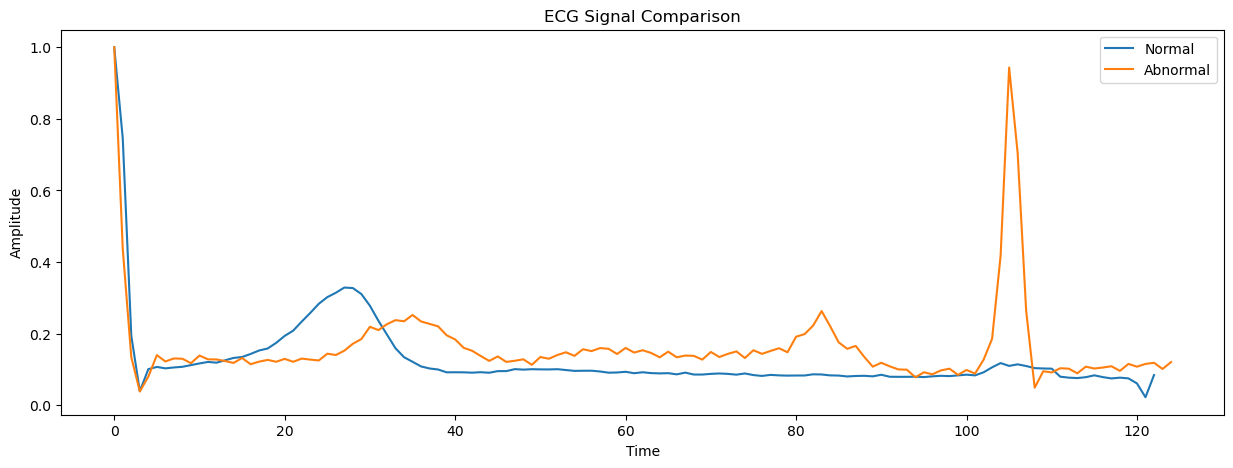

In [24]:
# visualize normal data
sample_normal = data_normal.iloc[:,:-1].sample(1).values.flatten()  # take single sample of a row, but not last column values
sample_normal = [s for s in sample_normal if s > 0]  # extract only values which are greater than 0
sample_abnormal = data_abnormal.iloc[:,:-1].sample(1).values.flatten()
sample_abnormal = [s for s in sample_abnormal if s > 0]

# plot
plt.figure(figsize=(15, 5))
plt.plot(sample_normal, label="Normal")
plt.plot(sample_abnormal, label="Abnormal")
plt.title("ECG Signal Comparison")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

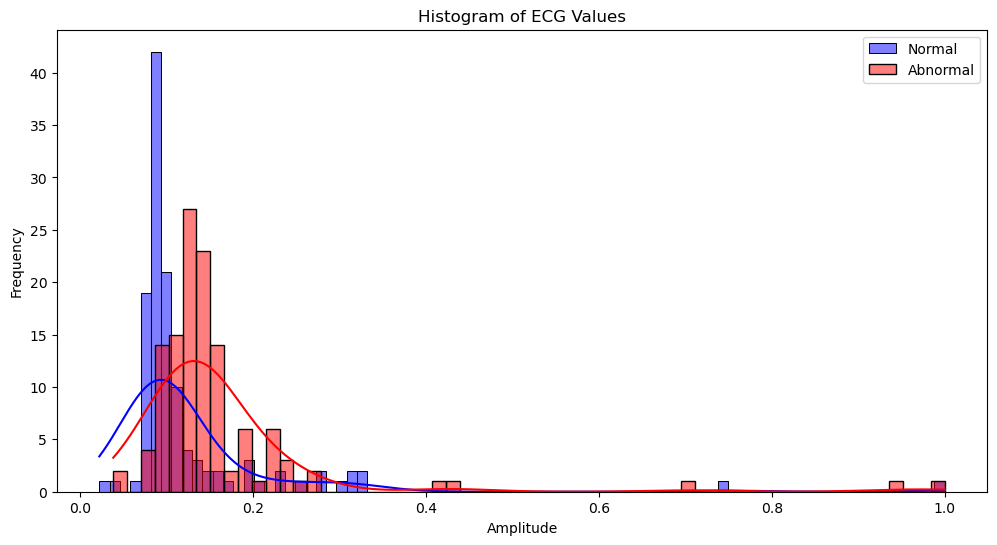

In [28]:
# plot distributions of values - Histogram
plt.figure(figsize=(12, 6))
sns.histplot(sample_normal, kde=True, color="blue", label="Normal")
sns.histplot(sample_abnormal, kde=True, color="red", label="Abnormal")
plt.title("Histogram of ECG Values")
plt.xlabel("Amplitude")
plt.ylabel("Frequency")
plt.legend()
plt.show()

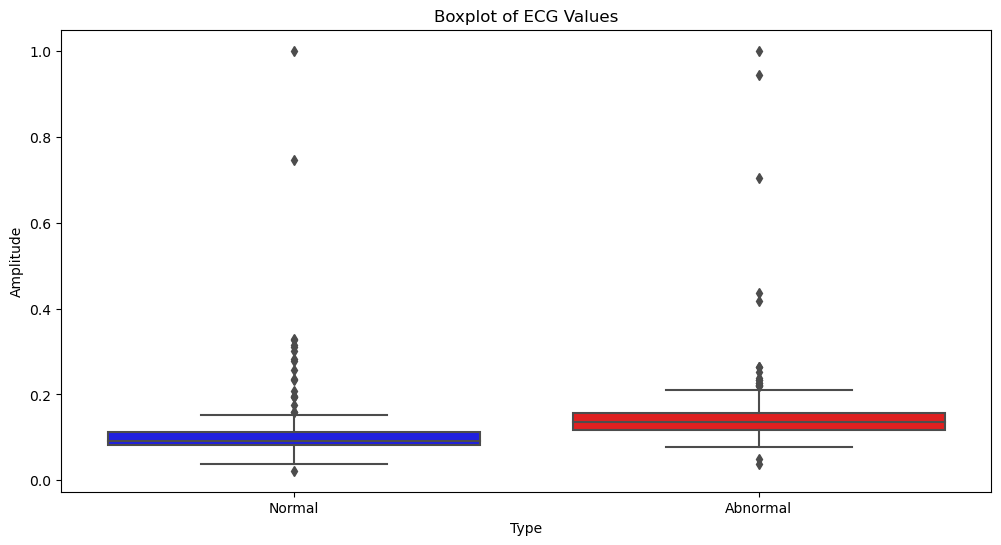

In [30]:
# plot distributions of values - Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=[sample_normal, sample_abnormal], palette=["blue", "red"])
plt.xticks([0, 1], ["Normal", "Abnormal"])
plt.title("Boxplot of ECG Values")
plt.xlabel("Type")
plt.ylabel("Amplitude")
plt.show()

## Decomposition

In [48]:
# decomposition requires a continous segment of time series data - "value" = ECG signal
data_normal["value"] = data_normal.mean(axis=1)
data_abnormal["value"] = data_abnormal.mean(axis=1)

# decompose time series model
decomposition_normal = seasonal_decompose(data_normal["value"], period=50, model="additive")
decomposition_abnormal = seasonal_decompose(data_abnormal["value"], period=50, model="additive")

segment = slice(0, 150)  # view on just a segment

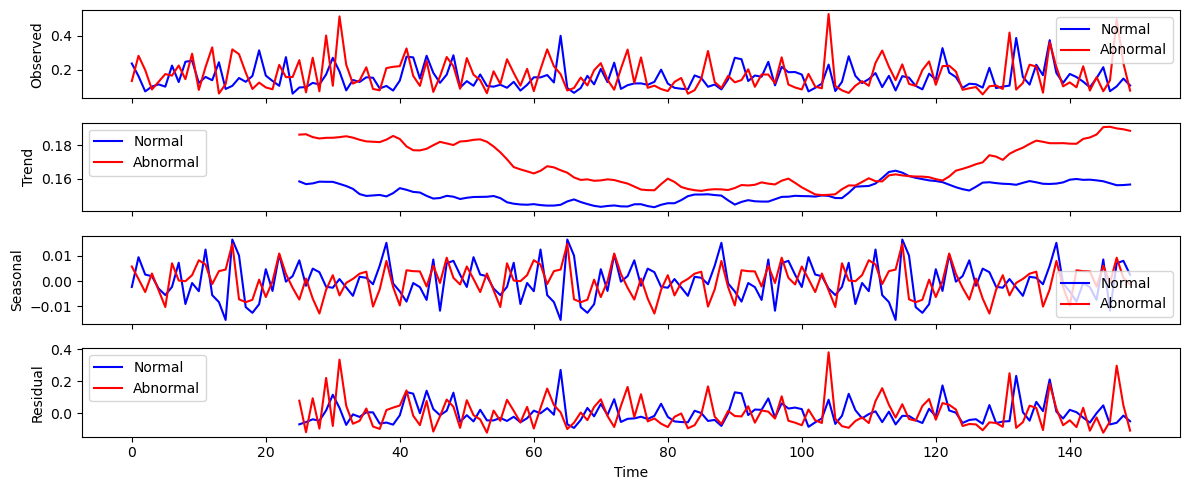

In [49]:
# plot decompositions
fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)

# observed
axes[0].plot(decomposition_normal.observed[segment], color="blue", label="Normal")
axes[0].plot(decomposition_abnormal.observed[segment], color="red", label="Abnormal")
axes[0].set_ylabel("Observed")
axes[0].legend()

# trend
axes[1].plot(decomposition_normal.trend[segment], color="blue", label="Normal")
axes[1].plot(decomposition_abnormal.trend[segment], color="red", label="Abnormal")
axes[1].set_ylabel("Trend")
axes[1].legend()

# seasonal
axes[2].plot(decomposition_normal.seasonal[segment], color="blue", label="Normal")
axes[2].plot(decomposition_abnormal.seasonal[segment], color="red", label="Abnormal")
axes[2].set_ylabel("Seasonal")
axes[2].legend()

# residual
axes[3].plot(decomposition_normal.resid[segment], color="blue", label="Normal")
axes[3].plot(decomposition_abnormal.resid[segment], color="red", label="Abnormal")
axes[3].set_ylabel("Residual")
axes[3].legend()
axes[3].set_xlabel("Time")

plt.tight_layout()
plt.show()

## Rolling Statistics

In [50]:
# calculate rolling statistics
rolling_mean_normal = data_normal["value"].rolling(window=50).mean()
rolling_std_normal = data_normal["value"].rolling(window=50).std()

rolling_mean_abnormal = data_abnormal["value"].rolling(window=50).mean()
rolling_std_abnormal = data_abnormal["value"].rolling(window=50).std()

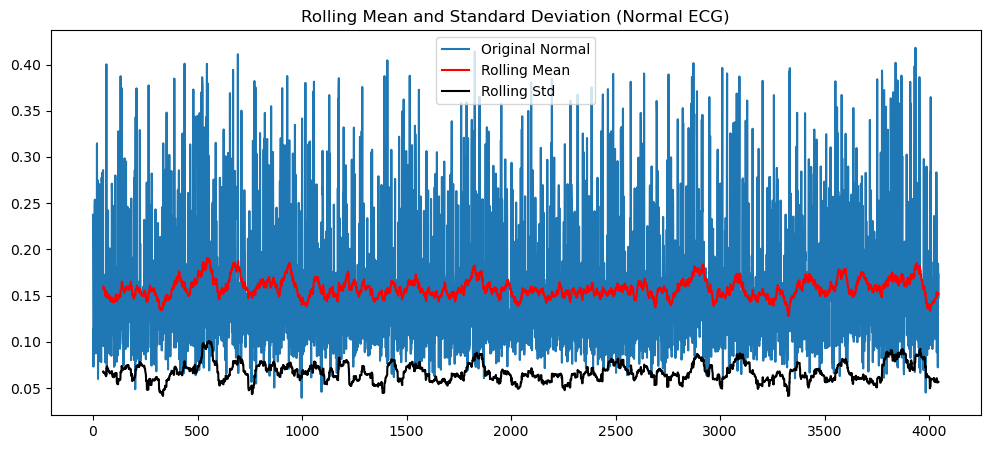

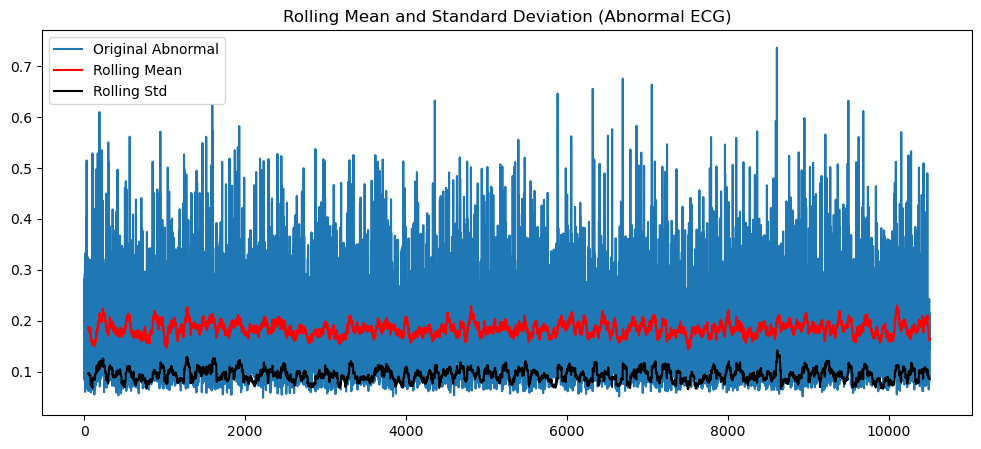

In [52]:
# plot rolling stats
plt.figure(figsize=(12, 5))
plt.plot(data_normal["value"], label="Original Normal")
plt.plot(rolling_mean_normal, label="Rolling Mean", color="red")
plt.plot(rolling_std_normal, label="Rolling Std", color="black")
plt.title("Rolling Mean and Standard Deviation (Normal ECG)")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(data_abnormal["value"], label="Original Abnormal")
plt.plot(rolling_mean_abnormal, label="Rolling Mean", color="red")
plt.plot(rolling_std_abnormal, label="Rolling Std", color="black")
plt.title("Rolling Mean and Standard Deviation (Abnormal ECG)")
plt.legend()
plt.show()

In [55]:
# calculate the Augmented Dickey-Fuller Test
# used to calculate the stationary affect of data - whether data like mean and variance changes over time
result_normal = adfuller(data_normal["value"])
result_abnormal = adfuller(data_abnormal["value"])

print("ADF Statistics (Normal):", result_normal[0])
print("p-value (Normal):", result_normal[1])

print("ADF Statistics (Abnormal):", result_abnormal[0])
print("p-value (Abnormal):", result_abnormal[1])

# data is described with a p-value < 0.05, the data is statistically stationary

ADF Statistics (Normal): -62.620317874660024
p-value (Normal): 0.0
ADF Statistics (Abnormal): -102.0725701195399
p-value (Abnormal): 0.0


## Autocorrelation Function and Partial Autocorrelation Function

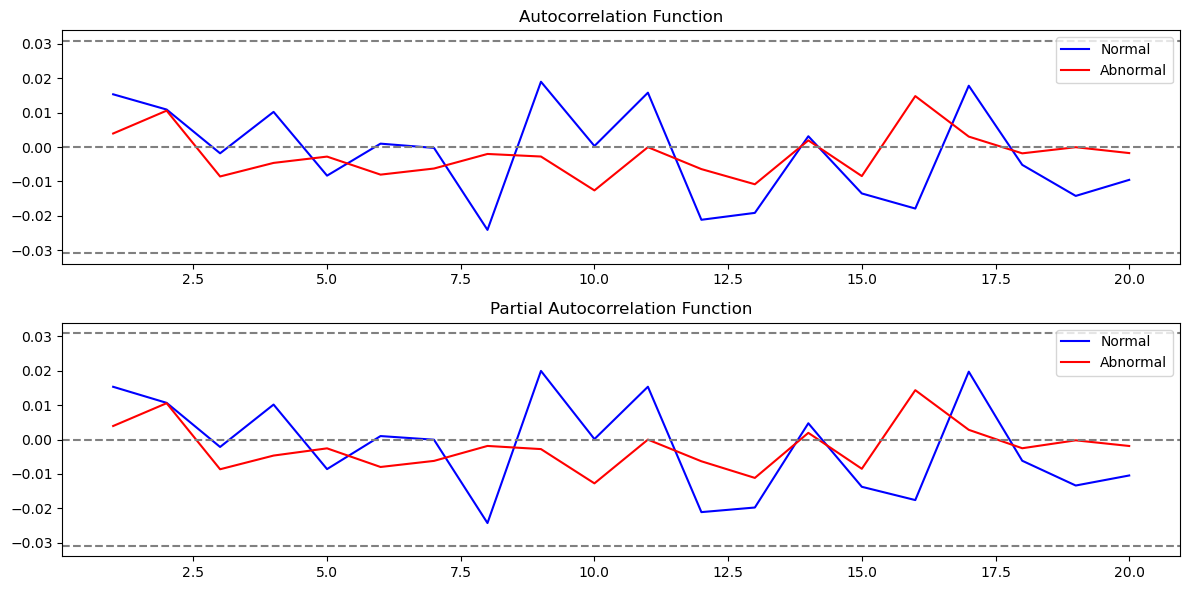

In [58]:
# create lagged datasets
lag_acf_normal = acf(data_normal["value"], nlags=20)[1:]  # exclude lag 0
lag_pacf_normal = pacf(data_normal["value"], nlags=20, method="ols")[1:]  # exclude lag 0

lag_acf_abnormal = acf(data_abnormal["value"], nlags=20)[1:]  # exclude lag 0
lag_pacf_abnormal = pacf(data_abnormal["value"], nlags=20, method="ols")[1:]  # exclude lag 0

# adjust visual lags to start from 1
lags = range(1, 21)

# plot acf visuals
plt.figure(figsize=(12, 6))

plt.subplot(211)
plt.plot(lags, lag_acf_normal, label="Normal", color="blue")
plt.plot(lags, lag_acf_abnormal, label="Abnormal", color="red")
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=1.96/np.sqrt(len(data_normal)), linestyle="--", color="gray")
plt.axhline(y=-1.96/np.sqrt(len(data_normal)), linestyle="--", color="gray")
plt.title("Autocorrelation Function")
plt.legend()

# plot pacf visuals
plt.subplot(212)
plt.plot(lags, lag_pacf_normal, label="Normal", color="blue")
plt.plot(lags, lag_pacf_abnormal, label="Abnormal", color="red")
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=1.96/np.sqrt(len(data_normal)), linestyle="--", color="gray")
plt.axhline(y=-1.96/np.sqrt(len(data_normal)), linestyle="--", color="gray")
plt.title("Partial Autocorrelation Function")
plt.legend()

plt.tight_layout()
plt.show()

## Modeling

In [88]:
# label column names
data_normal = pd.read_csv("data/ptbdb_normal.csv")
data_abnormal = pd.read_csv("data/ptbdb_abnormal.csv")

data_normal = data_normal.iloc[:, :-1]
data_abnormal = data_abnormal.iloc[:, :-1]

data_normal.columns = [f"feature_{i}" for i in range (data_normal.shape[1])]
data_abnormal.columns = [f"feature_{i}" for i in range (data_abnormal.shape[1])]

# add label column
data_normal["label"] = 0
data_abnormal["label"] = 1

# concat dataframes
data = pd.concat([data_normal, data_abnormal], axis=0).reset_index(drop=True)

# separate labels
labels = data["label"].values
data = data.drop("label", axis=1)

# handle null values using forward/backward fill
data = data.replace(0, np.nan)
data = data.fillna(method="ffill").fillna(method="bfill")

data = data.dropna(axis=1, how="all")
# data["label"] = labels

In [101]:
# split train test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# isolation forest model
iso_forest = IsolationForest(contamination=0.5, random_state=42)
iso_forest.fit(X_train)

# predict anomalies in test set
y_pred_train = iso_forest.predict(X_train)
y_pred_test = iso_forest.predict(X_test)

# convert predictions where -1 is anomaly, 1 is normal
y_pred_train = np.where(y_pred_train==-1, 1, 0)
y_pred_test = np.where(y_pred_test==-1, 1, 0)

AUPRC on the test set: 0.883


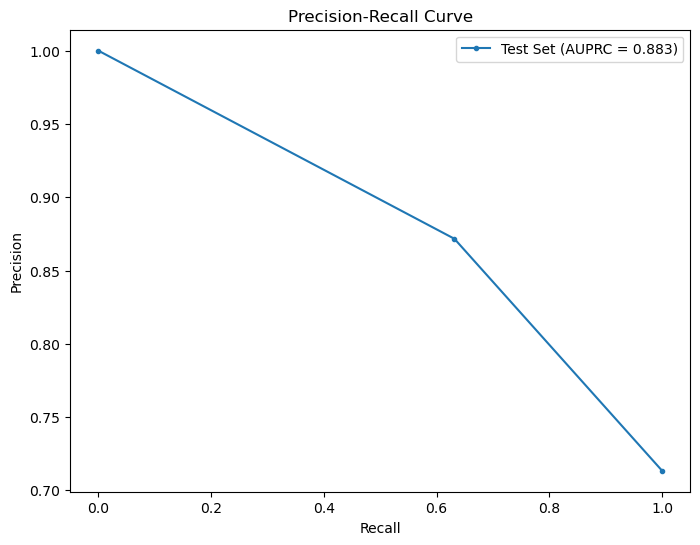

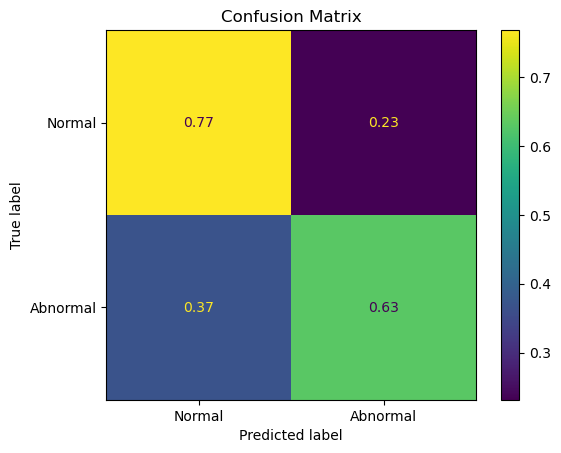

In [102]:
# calculate precision, recall, and AUC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_test)
auprc_test = auc(recall, precision)
print(f"AUPRC on the test set: {auprc_test:.3f}")

# plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker=".", label=f"Test Set (AUPRC = {auprc_test:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred_test, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [128]:
# autoencoder model
autoencoder = Sequential(
    [
        Input(shape=(X_train.shape[1],)),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(16, activation="relu"),
        Dense(8, activation="relu"),
        Dense(4, activation="relu"),
        Dense(8, activation="relu"),
        Dense(16, activation="relu"),
        Dense(32, activation="relu"),
        Dense(64, activation="relu"),
        Dense(X_train.shape[1], activation="sigmoid")
    ]
)

autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 64)             │        11,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 186)            │        12,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,678 (115.93 KB)

 Trainable params: 29,678 (115.93 KB)

 Non-trainable params: 0 (0.00 B)

In [129]:

# train model
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# evaluate the model on test
reconstructions = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.abs(reconstructions - X_test), axis=1)

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


AUPRC on the test set: 0.912


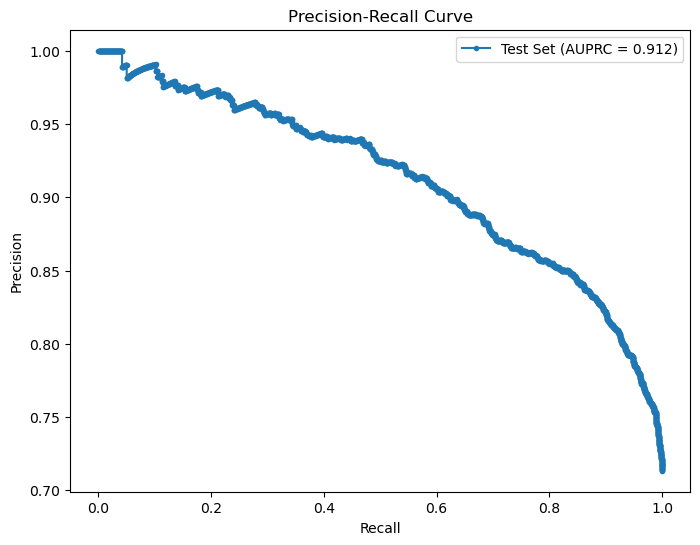

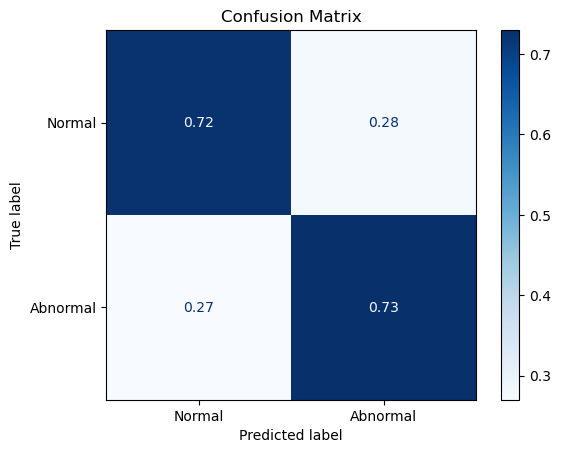

In [132]:
# calculate precision, recall, and AUC
precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_error)
auprc_test = auc(recall, precision)
print(f"AUPRC on the test set: {auprc_test:.3f}")

# plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker=".", label=f"Test Set (AUPRC = {auprc_test:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# plot confusion matrix
# best_threshold = thresholds[np.argmax(precision * recall)]  # threshold approach 1
best_threshold = np.percentile(reconstruction_error, 40)  # threshold approach 2
y_pred = (reconstruction_error > best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [141]:
data_normal = pd.read_csv("data/ptbdb_normal.csv")
data_abnormal = pd.read_csv("data/ptbdb_abnormal.csv")

# Remove the last column before concatenating
data_normal = data_normal.iloc[:, :-1]
data_abnormal = data_abnormal.iloc[:, :-1]

# Reset column names to ensure they are the same
data_normal.columns = [f'feature_{i}' for i in range(data_normal.shape[1])]
data_abnormal.columns = [f'feature_{i}' for i in range(data_abnormal.shape[1])]

# Add the label column
data_normal['label'] = 0
data_abnormal['label'] = 1

# Concatenate the dataframes along rows
data = pd.concat([data_normal, data_abnormal], axis=0).reset_index(drop=True)

# Separate labels before handling NaNs
labels = data['label'].values
data = data.drop('label', axis=1)

# Handling NaN values: Replace zeros with NaNs, then forward fill and backward fill
data = data.replace(0, np.nan)  # Assuming zeros are padding
data = data.fillna(method='ffill').fillna(method='bfill')  # Forward and backward fill

# Drop columns with all NaN values after filling
data = data.dropna(axis=1, how='all')

# Reattach labels
data['label'] = labels

# Ensure there is no empty data after handling NaNs
if data.empty:
    raise ValueError("Dataframe is empty after handling NaN values")

labels = data['label'].values
data = data.drop('label', axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Print class weights
print(f"Class weights: {class_weight_dict}")

# Scale the data after splitting
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Increase the number of timesteps for the input
timesteps = 10  # Adjust this value to see its effect
n_features = X_train.shape[1] // timesteps  # go n steps into the future (each feature is a point in time)
X_train = X_train[:, :n_features * timesteps]
X_train = X_train.reshape((X_train.shape[0], timesteps, n_features))
X_test = X_test[:, :n_features * timesteps]
X_test = X_test.reshape((X_test.shape[0], timesteps, n_features))

Class weights: {0: 1.8125194643413267, 1: 0.690473365761063}


In [142]:
# Build LSTM Autoencoder
lstm_autoencoder = Sequential([
    Input(shape=(timesteps, n_features)),
    LSTM(128, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    RepeatVector(timesteps),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(n_features))
])
lstm_autoencoder.compile(optimizer='adam', loss='mse')
lstm_autoencoder.summary()

c:\Users\EV-04\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 18)         │         2,322 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,834 (1011.07 KB)

 Trainable params: 258,834 (1011.07 KB)

 Non-trainable params: 0 (0.00 B)

In [143]:
# Train the LSTM Autoencoder with class weights
lstm_autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate on the final test set
reconstructions = lstm_autoencoder.predict(X_test)
reconstruction_error = np.mean(np.abs(reconstructions - X_test), axis=2).mean(axis=1)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


AUPRC on the test set: 0.917


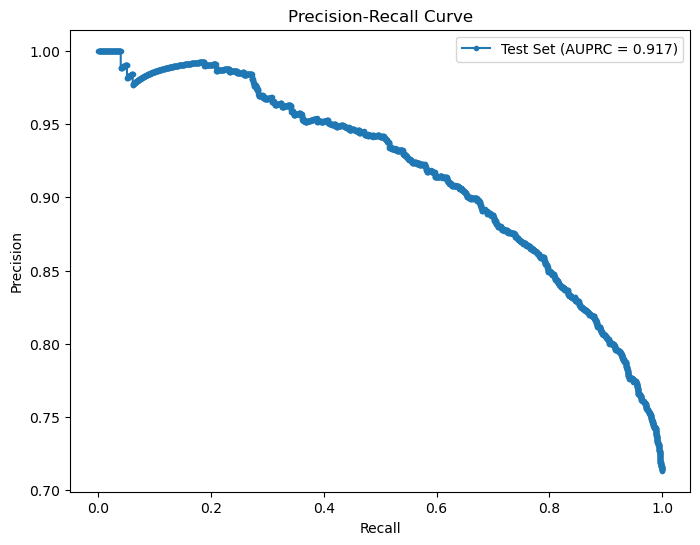

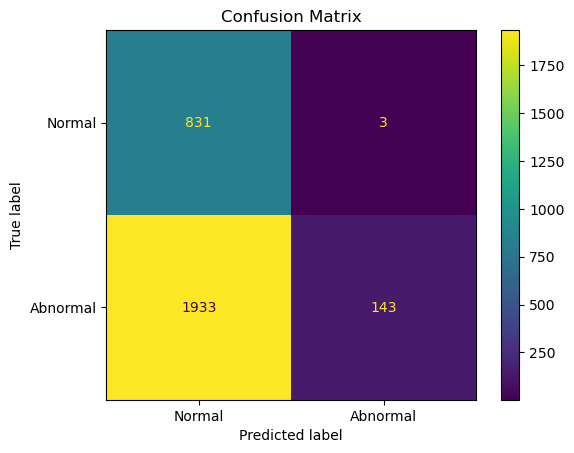

In [144]:
# Precision-Recall curve and AUPRC
precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_error)
auprc_test = auc(recall, precision)
print(f'AUPRC on the test set: {auprc_test:.3f}')

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Test Set (AUPRC = {auprc_test:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Confusion Matrix
threshold = np.percentile(reconstruction_error, 95)  # Example threshold
y_pred = (reconstruction_error > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()


In [145]:
# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Print class weights
print(f"Class weights: {class_weight_dict}")

Class weights: {0: 1.8125194643413267, 1: 0.690473365761063}


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 10, 128)        │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 18)         │         2,322 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,834 (1011.07 KB)

 Trainable params: 258,834 (1011.07 KB)

 Non-trainable params: 0 (0.00 B)

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
AUPRC on the test set: 0.902


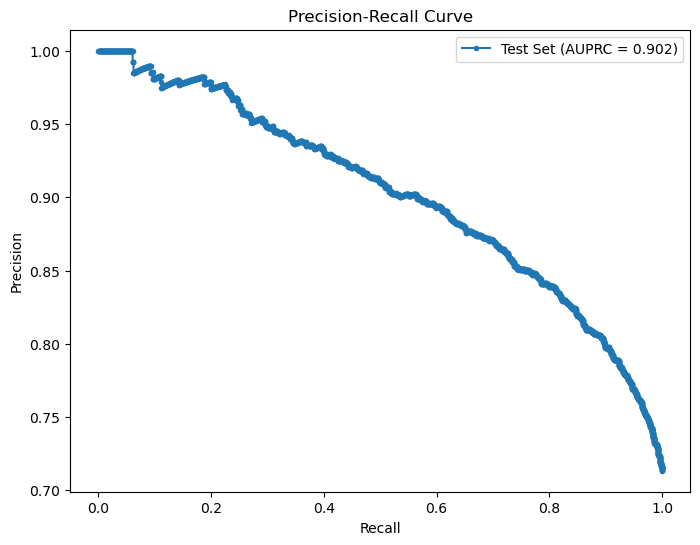

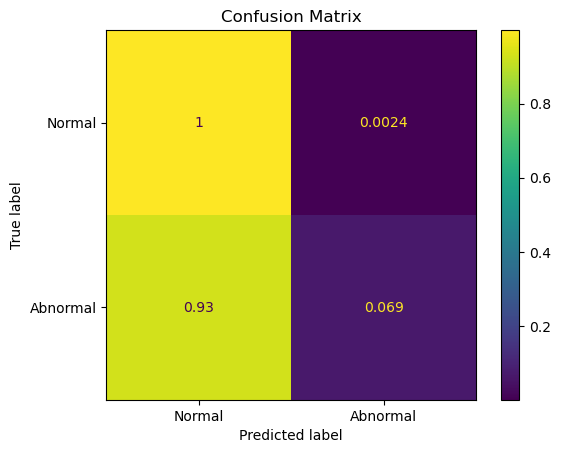

In [147]:
data_normal = pd.read_csv("data/ptbdb_normal.csv")
data_abnormal = pd.read_csv("data/ptbdb_abnormal.csv")

# Remove the last column before concatenating
data_normal = data_normal.iloc[:, :-1]
data_abnormal = data_abnormal.iloc[:, :-1]

# Reset column names to ensure they are the same
data_normal.columns = [f'feature_{i}' for i in range(data_normal.shape[1])]
data_abnormal.columns = [f'feature_{i}' for i in range(data_abnormal.shape[1])]

# Add the label column
data_normal['label'] = 0
data_abnormal['label'] = 1

# Concatenate the dataframes along rows
data = pd.concat([data_normal, data_abnormal], axis=0).reset_index(drop=True)

# Separate labels before handling NaNs
labels = data['label'].values
data = data.drop('label', axis=1)

# Handling NaN values: Replace zeros with NaNs, then forward fill and backward fill
data = data.replace(0, np.nan)  # Assuming zeros are padding
data = data.fillna(method='ffill').fillna(method='bfill')  # Forward and backward fill

# Drop columns with all NaN values after filling
data = data.dropna(axis=1, how='all')

# Reattach labels
data['label'] = labels

# Ensure there is no empty data after handling NaNs
if data.empty:
    raise ValueError("Dataframe is empty after handling NaN values")

labels = data['label'].values
data = data.drop('label', axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Scale the data after splitting
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Increase the number of timesteps for the input
timesteps = 10  # Adjust this value to see its effect
n_features = X_train.shape[1] // timesteps
X_train = X_train[:, :n_features * timesteps]
X_train = X_train.reshape((X_train.shape[0], timesteps, n_features))
X_test = X_test[:, :n_features * timesteps]
X_test = X_test.reshape((X_test.shape[0], timesteps, n_features))

# Build LSTM Autoencoder
lstm_autoencoder = Sequential([
    Input(shape=(timesteps, n_features)),
    LSTM(128, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    RepeatVector(timesteps),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(n_features))
])
lstm_autoencoder.compile(optimizer='adam', loss='mae')
lstm_autoencoder.summary()

# Train the LSTM Autoencoder
lstm_autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate on the final test set
reconstructions = lstm_autoencoder.predict(X_test)
reconstruction_error = np.mean(np.abs(reconstructions - X_test), axis=2).mean(axis=1)

# Precision-Recall curve and AUPRC
precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_error)
auprc_test = auc(recall, precision)
print(f'AUPRC on the test set: {auprc_test:.3f}')

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Test Set (AUPRC = {auprc_test:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Confusion Matrix
threshold = np.percentile(reconstruction_error, 95)  # Example threshold
y_pred = (reconstruction_error > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

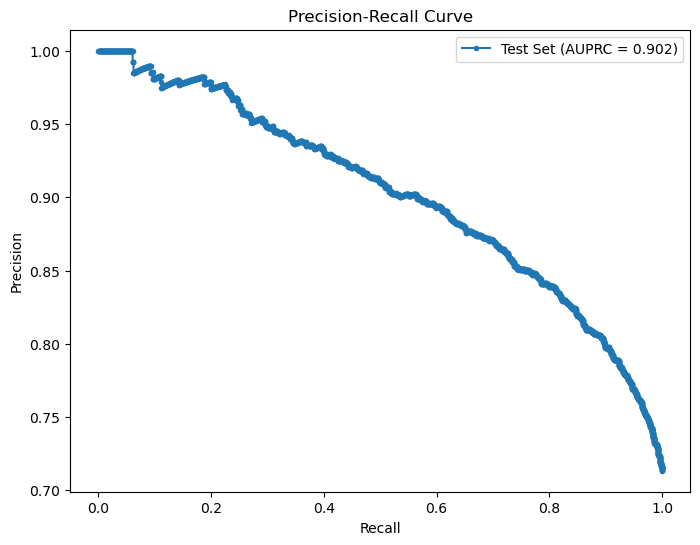

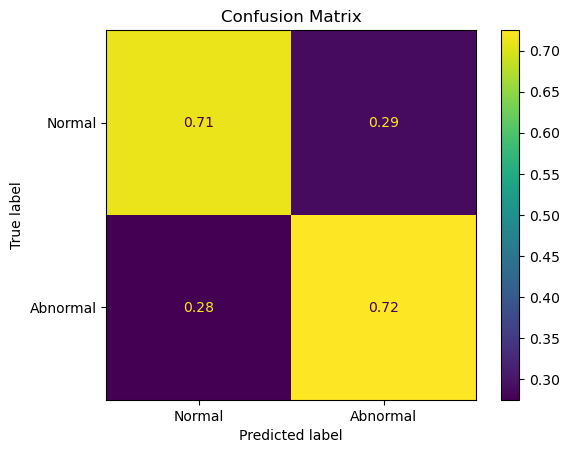

In [148]:
best_threshold = np.percentile(reconstruction_error, 40)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Test Set (AUPRC = {auprc_test:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Confusion Matrix using the best threshold
y_pred = (reconstruction_error > best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

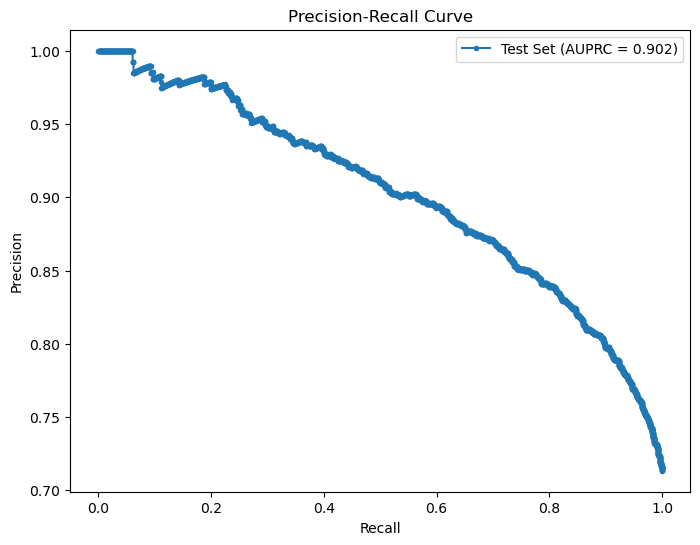

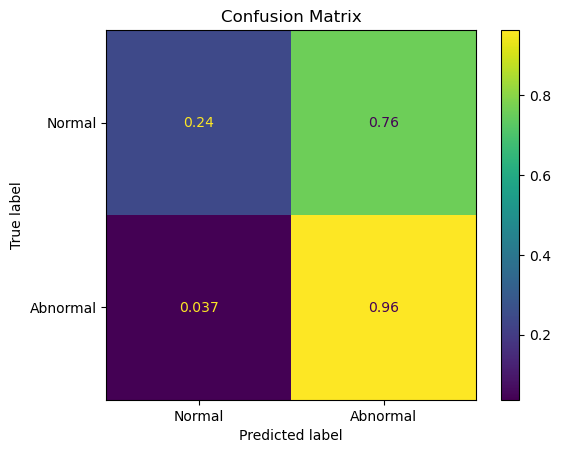

In [149]:
# Find the best threshold based on the Precision-Recall curve
best_threshold = thresholds[np.argmax(precision * recall)]

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Test Set (AUPRC = {auprc_test:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Confusion Matrix using the best threshold
y_pred = (reconstruction_error > best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

Class weights: {0: 1.8125194643413267, 1: 0.690473365761063}


c:\Users\EV-04\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 10, 128)        │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 18)         │         2,322 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,834 (1011.07 KB)

 Trainable params: 258,834 (1011.07 KB)

 Non-trainable params: 0 (0.00 B)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
AUPRC on the test set: 0.898


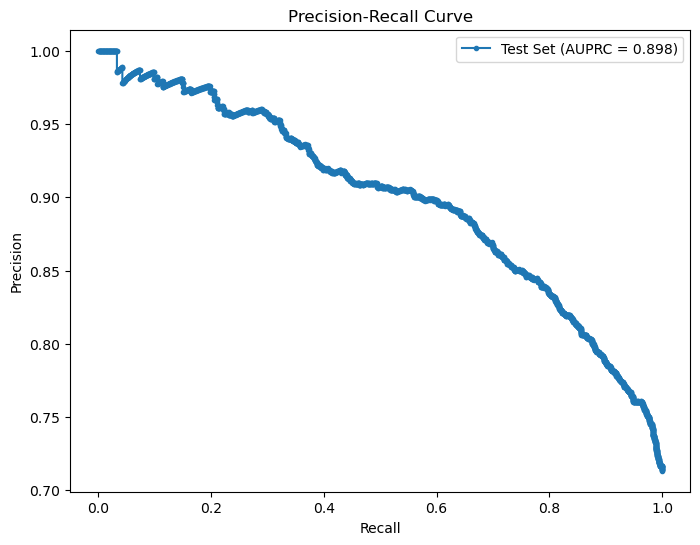

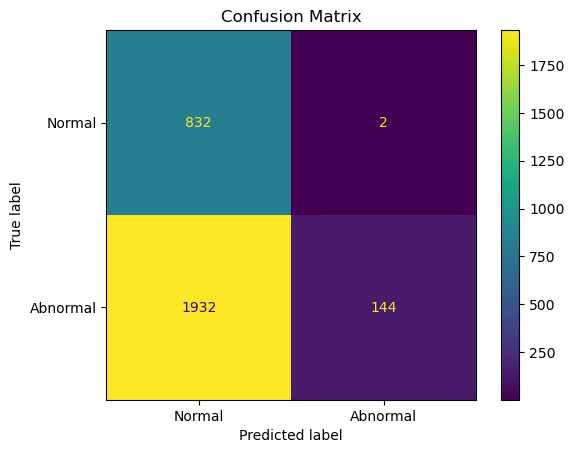

In [151]:
data_normal = pd.read_csv('data/ptbdb_normal.csv')
data_abnormal = pd.read_csv('data/ptbdb_abnormal.csv')

# Remove the last column before concatenating
data_normal = data_normal.iloc[:, :-1]
data_abnormal = data_abnormal.iloc[:, :-1]

# Reset column names to ensure they are the same
data_normal.columns = [f'feature_{i}' for i in range(data_normal.shape[1])]
data_abnormal.columns = [f'feature_{i}' for i in range(data_abnormal.shape[1])]

# Add the label column
data_normal['label'] = 0
data_abnormal['label'] = 1

# Concatenate the dataframes along rows
data = pd.concat([data_normal, data_abnormal], axis=0).reset_index(drop=True)

# Separate labels before handling NaNs
labels = data['label'].values
data = data.drop('label', axis=1)

# Handling NaN values: Replace zeros with NaNs, then forward fill and backward fill
data = data.replace(0, np.nan)  # Assuming zeros are padding
data = data.fillna(method='ffill').fillna(method='bfill')  # Forward and backward fill

# Drop columns with all NaN values after filling
data = data.dropna(axis=1, how='all')

# Reattach labels
data['label'] = labels

# Ensure there is no empty data after handling NaNs
if data.empty:
    raise ValueError("Dataframe is empty after handling NaN values")

labels = data['label'].values
data = data.drop('label', axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Print class weights
print(f"Class weights: {class_weight_dict}")

# Scale the data after splitting
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Increase the number of timesteps for the input
timesteps = 10  # Adjust this value to see its effect
n_features = X_train.shape[1] // timesteps
X_train = X_train[:, :n_features * timesteps]
X_train = X_train.reshape((X_train.shape[0], timesteps, n_features))
X_test = X_test[:, :n_features * timesteps]
X_test = X_test.reshape((X_test.shape[0], timesteps, n_features))

# Build LSTM Autoencoder
lstm_autoencoder = Sequential([
    LSTM(128, activation='relu', input_shape=(timesteps, n_features), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    RepeatVector(timesteps),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(n_features))
])
lstm_autoencoder.compile(optimizer='adam', loss='mae')
lstm_autoencoder.summary()

# Train the LSTM Autoencoder with class weights
lstm_autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate on the final test set
reconstructions = lstm_autoencoder.predict(X_test)
reconstruction_error = np.mean(np.abs(reconstructions - X_test), axis=2).mean(axis=1)

# Precision-Recall curve and AUPRC
precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_error)
auprc_test = auc(recall, precision)
print(f'AUPRC on the test set: {auprc_test:.3f}')

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Test Set (AUPRC = {auprc_test:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Confusion Matrix
threshold = np.percentile(reconstruction_error, 95)  # Example threshold
y_pred = (reconstruction_error > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()


157/364 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step

c:\Users\EV-04\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step


c:\Users\EV-04\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 1, 128)         │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 1, 896)         │       115,584 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 821,632 (3.13 MB)

 Trainable params: 821,632 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
AUPRC on the test set: 0.893


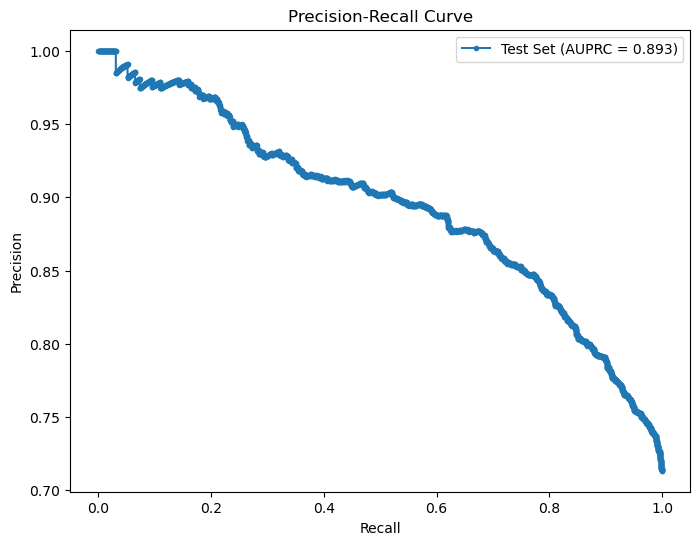

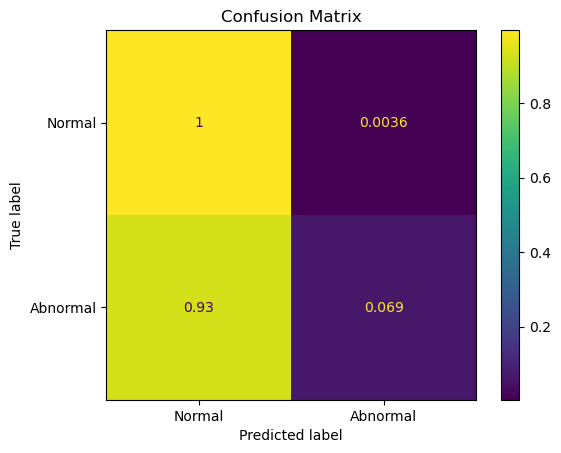

In [152]:
data_normal = pd.read_csv('data/ptbdb_normal.csv')
data_abnormal = pd.read_csv('data/ptbdb_abnormal.csv')

# Remove the last column before concatenating
data_normal = data_normal.iloc[:, :-1]
data_abnormal = data_abnormal.iloc[:, :-1]

# Reset column names to ensure they are the same
data_normal.columns = [f'feature_{i}' for i in range(data_normal.shape[1])]
data_abnormal.columns = [f'feature_{i}' for i in range(data_abnormal.shape[1])]

# Add the label column
data_normal['label'] = 0
data_abnormal['label'] = 1

# Concatenate the dataframes along rows
data = pd.concat([data_normal, data_abnormal], axis=0).reset_index(drop=True)

# Separate labels before handling NaNs
labels = data['label'].values
data = data.drop('label', axis=1)

# Handling NaN values: Replace zeros with NaNs, then forward fill and backward fill
data = data.replace(0, np.nan)  # Assuming zeros are padding
data = data.fillna(method='ffill').fillna(method='bfill')  # Forward and backward fill

# Drop columns with all NaN values after filling
data = data.dropna(axis=1, how='all')

# Reattach labels
data['label'] = labels

# Ensure there is no empty data after handling NaNs
if data.empty:
    raise ValueError("Dataframe is empty after handling NaN values")

labels = data['label'].values
data = data.drop('label', axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Scale the data after splitting
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Increase the number of timesteps for the input
timesteps = 30
n_features = X_train.shape[1] // timesteps
X_train = X_train[:, :n_features * timesteps]
X_train = X_train.reshape((X_train.shape[0], timesteps, n_features))
X_test = X_test[:, :n_features * timesteps]
X_test = X_test.reshape((X_test.shape[0], timesteps, n_features))

# Build CNN for feature extraction
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(timesteps, n_features)),
    MaxPooling1D(pool_size=2),
    Flatten()
])
cnn_model.compile(optimizer='adam', loss='mse')

# Extract features using the CNN model
cnn_features_train = cnn_model.predict(X_train)
cnn_features_test = cnn_model.predict(X_test)

cnn_features_train = cnn_features_train.reshape((cnn_features_train.shape[0], 1, -1))
cnn_features_test = cnn_features_test.reshape((cnn_features_test.shape[0], 1, -1))

# Build LSTM Autoencoder
lstm_autoencoder = Sequential([
    LSTM(128, activation='relu', input_shape=(1, cnn_features_train.shape[2]), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    RepeatVector(1),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(cnn_features_train.shape[2]))
])
lstm_autoencoder.compile(optimizer='adam', loss='mse')
lstm_autoencoder.summary()

# Train the LSTM Autoencoder
lstm_autoencoder.fit(cnn_features_train, cnn_features_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate on the test set
reconstructions = lstm_autoencoder.predict(cnn_features_test)
reconstruction_error = np.mean(np.abs(reconstructions - cnn_features_test), axis=2).flatten()

# Precision-Recall curve and AUPRC
precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_error)
auprc_test = auc(recall, precision)
print(f'AUPRC on the test set: {auprc_test:.3f}')

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Test Set (AUPRC = {auprc_test:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Confusion Matrix
threshold = np.percentile(reconstruction_error, 95)  # Example threshold
y_pred = (reconstruction_error > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

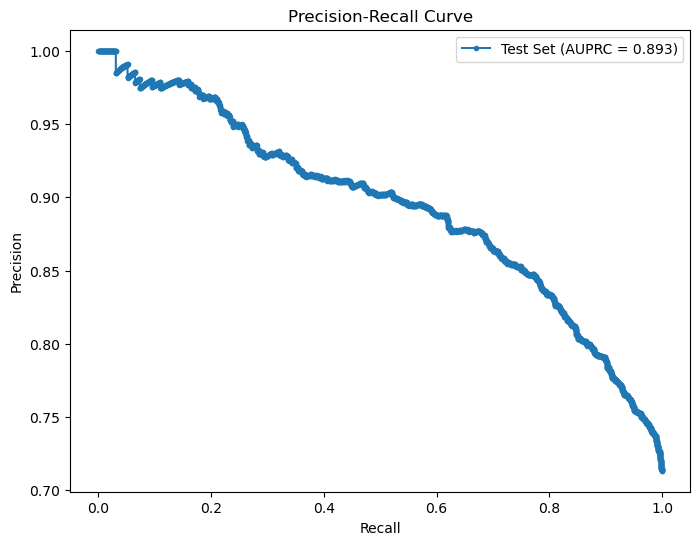

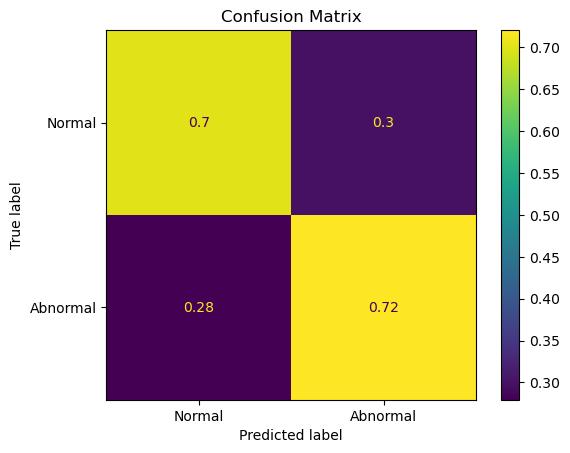

In [153]:
best_threshold = np.percentile(reconstruction_error, 40)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Test Set (AUPRC = {auprc_test:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Confusion Matrix using the best threshold
y_pred = (reconstruction_error > best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

163/364 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step

c:\Users\EV-04\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step


c:\Users\EV-04\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 1, 128)         │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_5 (RepeatVector)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 1, 896)         │       115,584 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 821,632 (3.13 MB)

 Trainable params: 821,632 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
AUPRC on the test set: 0.836


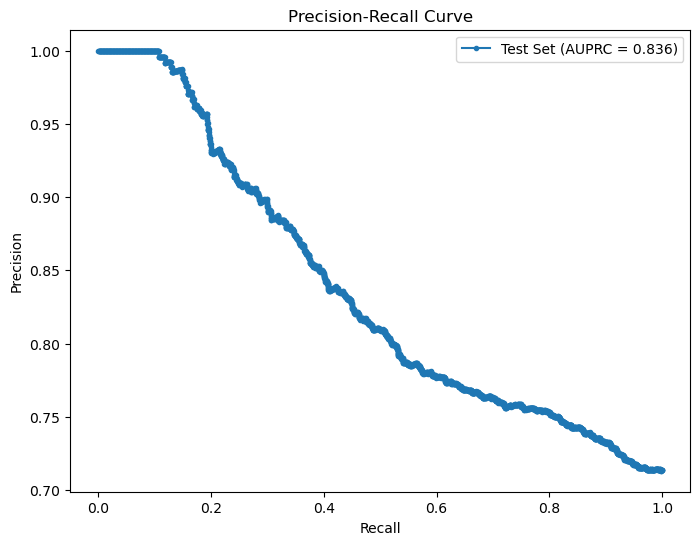

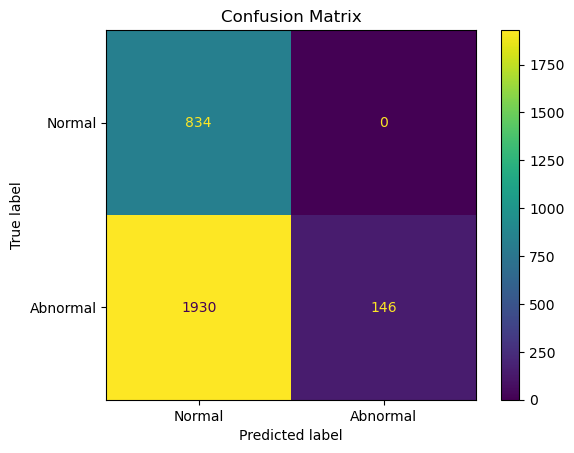

In [154]:
data_normal = pd.read_csv('data/ptbdb_normal.csv')
data_abnormal = pd.read_csv('data/ptbdb_abnormal.csv')

# Remove the last column before concatenating
data_normal = data_normal.iloc[:, :-1]
data_abnormal = data_abnormal.iloc[:, :-1]

# Reset column names to ensure they are the same
data_normal.columns = [f'feature_{i}' for i in range(data_normal.shape[1])]
data_abnormal.columns = [f'feature_{i}' for i in range(data_abnormal.shape[1])]

# Add the label column
data_normal['label'] = 0
data_abnormal['label'] = 1

# Concatenate the dataframes along rows
data = pd.concat([data_normal, data_abnormal], axis=0).reset_index(drop=True)

# Separate labels before handling NaNs
labels = data['label'].values
data = data.drop('label', axis=1)

# Handling NaN values: Replace zeros with NaNs, then forward fill and backward fill
data = data.replace(0, np.nan)  # Assuming zeros are padding
data = data.fillna(method='ffill').fillna(method='bfill')  # Forward and backward fill

# Drop columns with all NaN values after filling
data = data.dropna(axis=1, how='all')

# Reattach labels
data['label'] = labels

# Ensure there is no empty data after handling NaNs
if data.empty:
    raise ValueError("Dataframe is empty after handling NaN values")

labels = data['label'].values
data = data.drop('label', axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Scale the data after splitting
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Increase the number of timesteps for the input
timesteps = 30
n_features = X_train.shape[1] // timesteps
X_train = X_train[:, :n_features * timesteps]
X_train = X_train.reshape((X_train.shape[0], timesteps, n_features))
X_test = X_test[:, :n_features * timesteps]
X_test = X_test.reshape((X_test.shape[0], timesteps, n_features))

# Build CNN for feature extraction
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(timesteps, n_features), kernel_regularizer='l2'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten()
])
cnn_model.compile(optimizer='adam', loss='mse')

# Extract features using the CNN model
cnn_features_train = cnn_model.predict(X_train)
cnn_features_test = cnn_model.predict(X_test)

cnn_features_train = cnn_features_train.reshape((cnn_features_train.shape[0], 1, -1))
cnn_features_test = cnn_features_test.reshape((cnn_features_test.shape[0], 1, -1))

# Build LSTM Autoencoder
lstm_autoencoder = Sequential([
    LSTM(128, activation='relu', input_shape=(1, cnn_features_train.shape[2]), return_sequences=True, kernel_regularizer='l2'),
    Dropout(0.3),
    LSTM(64, activation='relu', return_sequences=False, kernel_regularizer='l2'),
    RepeatVector(1),
    LSTM(64, activation='relu', return_sequences=True, kernel_regularizer='l2'),
    Dropout(0.3),
    LSTM(128, activation='relu', return_sequences=True, kernel_regularizer='l2'),
    TimeDistributed(Dense(cnn_features_train.shape[2]))
])
lstm_autoencoder.compile(optimizer='adam', loss='mse')
lstm_autoencoder.summary()

# Train the LSTM Autoencoder
lstm_autoencoder.fit(cnn_features_train, cnn_features_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate on the test set
reconstructions = lstm_autoencoder.predict(cnn_features_test)
reconstruction_error = np.mean(np.abs(reconstructions - cnn_features_test), axis=2).flatten()

# Precision-Recall curve and AUPRC
precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_error)
auprc_test = auc(recall, precision)
print(f'AUPRC on the test set: {auprc_test:.3f}')

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Test Set (AUPRC = {auprc_test:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Confusion Matrix
threshold = np.percentile(reconstruction_error, 95)  # Example threshold
y_pred = (reconstruction_error > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [155]:
data_normal = pd.read_csv('data/ptbdb_normal.csv')
data_abnormal = pd.read_csv('data/ptbdb_abnormal.csv')

# Remove the last column before concatenating
data_normal = data_normal.iloc[:, :-1]
data_abnormal = data_abnormal.iloc[:, :-1]

# Reset column names to ensure they are the same
data_normal.columns = [f'feature_{i}' for i in range(data_normal.shape[1])]
data_abnormal.columns = [f'feature_{i}' for i in range(data_abnormal.shape[1])]

# Add the label column
data_normal['label'] = 0
data_abnormal['label'] = 1

# Concatenate the dataframes along rows
data = pd.concat([data_normal, data_abnormal], axis=0).reset_index(drop=True)

# Separate labels before handling NaNs
labels = data['label'].values
data = data.drop('label', axis=1)

# Handling NaN values: Replace zeros with NaNs, then forward fill and backward fill
data = data.replace(0, np.nan)  # Assuming zeros are padding
data = data.fillna(method='ffill').fillna(method='bfill')  # Forward and backward fill

# Drop columns with all NaN values after filling
data = data.dropna(axis=1, how='all')

# Reattach labels
data['label'] = labels

# Ensure there is no empty data after handling NaNs
if data.empty:
    raise ValueError("Dataframe is empty after handling NaN values")

labels = data['label'].values
data = data.drop('label', axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Scale the data after splitting
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Increase the number of timesteps for the input
timesteps = 10
n_features = X_train_full.shape[1] // timesteps
X_train_full = X_train_full[:, :n_features * timesteps]
X_train_full = X_train_full.reshape((X_train_full.shape[0], timesteps, n_features))
X_test = X_test[:, :n_features * timesteps]
X_test = X_test.reshape((X_test.shape[0], timesteps, n_features))

# Build CNN for feature extraction
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(timesteps, n_features)),
    MaxPooling1D(pool_size=2),
    Flatten()
])
cnn_model.compile(optimizer='adam', loss='mse')

# Extract features using the CNN model
cnn_features_train_full = cnn_model.predict(X_train_full)
cnn_features_test = cnn_model.predict(X_test)

cnn_features_train_full = cnn_features_train_full.reshape((cnn_features_train_full.shape[0], 1, -1))
cnn_features_test = cnn_features_test.reshape((cnn_features_test.shape[0], 1, -1))

# K-Fold Cross-Validation on extracted features
kf = KFold(n_splits=5, shuffle=True, random_state=42)
auprc_scores = []
precision_vals = []
recall_vals = []

for k, (train_index, val_index) in enumerate(kf.split(cnn_features_train_full)):
    print(f"Fold {k+1}")
    X_train, X_val = cnn_features_train_full[train_index], cnn_features_train_full[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    # Ensure y_val is 1D
    y_val = y_val.flatten()

    # Build LSTM Autoencoder
    lstm_autoencoder = Sequential([
        LSTM(128, activation='relu', input_shape=(1, X_train.shape[2]), return_sequences=True),
        LSTM(64, activation='relu', return_sequences=False),
        RepeatVector(1),
        LSTM(64, activation='relu', return_sequences=True),
        LSTM(128, activation='relu', return_sequences=True),
        TimeDistributed(Dense(X_train.shape[2]))
    ])
    lstm_autoencoder.compile(optimizer='adam', loss='mse')
    lstm_autoencoder.summary()

    # Train the LSTM Autoencoder
    lstm_autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    # Reconstruction error
    reconstructions = lstm_autoencoder.predict(X_val)
    reconstruction_error = np.mean(np.abs(reconstructions - X_val), axis=2).flatten()

    # Precision-Recall curve and AUPRC
    precision, recall, thresholds = precision_recall_curve(y_val, reconstruction_error)
    auprc = auc(recall, precision)
    auprc_scores.append(auprc)
    precision_vals.append(precision)
    recall_vals.append(recall)

# Average AUPRC
average_auprc = np.mean(auprc_scores)
print(f'Average AUPRC over {kf.n_splits} folds: {average_auprc:.3f}')

# Train LSTM Autoencoder on the full training set
lstm_autoencoder.fit(cnn_features_train_full, cnn_features_train_full, epochs=50, batch_size=32, verbose=0)

# Evaluate on the final test set
reconstructions = lstm_autoencoder.predict(cnn_features_test)
reconstruction_error = np.mean(np.abs(reconstructions - cnn_features_test), axis=2).flatten()

precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_error)
auprc_test = auc(recall, precision)
print(f'AUPRC on the test set: {auprc_test:.3f}')

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
for i in range(len(precision_vals)):
    plt.plot(recall_vals[i], precision_vals[i], label=f'Fold {i+1}')
plt.plot(recall, precision, marker='.', label=f'Test Set (AUPRC = {auprc_test:.3f})', linewidth=2, color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Confusion Matrix
threshold = np.percentile(reconstruction_error, 95)  # Example threshold
y_pred = (reconstruction_error > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

NameError: name 'X_train_full' is not defined

In [ ]:
data_normal = pd.read_csv('data/ptbdb_normal.csv')
data_abnormal = pd.read_csv('data/ptbdb_abnormal.csv')

data_normal = data_normal.iloc[:, :-1]
data_abnormal = data_abnormal.iloc[:, :-1]

# Reset column names to ensure they are the same
data_normal.columns = [f'feature_{i}' for i in range(data_normal.shape[1])]
data_abnormal.columns = [f'feature_{i}' for i in range(data_abnormal.shape[1])]

# Add the label column
data_normal['label'] = 0
data_abnormal['label'] = 1

data = pd.concat([data_normal, data_abnormal], axis = 0).reset_index(drop=True)

# Handling NaN values: Replace zeros with NaNs, then forward fill and backward fill
data = data.replace(0, np.nan)  # Assuming zeros are padding
data = data.fillna(method='ffill').fillna(method='bfill')  # Forward and backward fill

# Drop columns with all NaN values after filling
data = data.dropna(axis=1, how='all')

# Ensure there is no empty data after handling NaNs
if data.empty:
    raise ValueError("Dataframe is empty after handling NaN values")

labels = data['label'].values
data = data.drop('label', axis=1)

# Split the data into training and final test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Scale the data after splitting
scaler = MinMaxScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

# Increase the number of timesteps for the input
timesteps = 10
n_features = X_train_full.shape[1] // timesteps
X_train_full = X_train_full[:, :n_features * timesteps]
X_train_full = X_train_full.reshape((X_train_full.shape[0], timesteps, n_features))
X_test = X_test[:, :n_features * timesteps]
X_test = X_test.reshape((X_test.shape[0], timesteps, n_features))

# Build CNN for feature extraction
cnn_model = Sequential(name='cnn_feature_extractor')
cnn_model.add(Conv1D(filters=64,
                     kernel_size=2,
                     activation='relu',
                     input_shape=(timesteps, n_features)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.compile(optimizer='adam', loss='mse')

# Extract features using the CNN model
cnn_features_train_full = cnn_model.predict(X_train_full)
cnn_features_test = cnn_model.predict(X_test)

cnn_features_train_full = cnn_features_train_full.reshape((cnn_features_train_full.shape[0], 1, -1))
cnn_features_test = cnn_features_test.reshape((cnn_features_test.shape[0], 1, -1))

# K-Fold Cross-Validation on extracted features
kf = KFold(n_splits=5, shuffle=True, random_state=42)
auprc_scores = []
precision_vals = []
recall_vals = []

for train_index, val_index in kf.split(cnn_features_train_full):
    print("----------------K FOLD START------------------------")
    X_train, X_val = cnn_features_train_full[train_index], cnn_features_train_full[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    # Ensure y_val is 1D
    y_val = y_val.flatten()

    # Build LSTM Autoencoder
    lstm_autoencoder = Sequential([
        LSTM(128, activation='relu', input_shape=(1, X_train.shape[2]), return_sequences=True),
        LSTM(64, activation='relu', return_sequences=False),
        RepeatVector(1),
        LSTM(64, activation='relu', return_sequences=True),
        LSTM(128, activation='relu', return_sequences=True),
        TimeDistributed(Dense(X_train.shape[2]))
    ])
    lstm_autoencoder.compile(optimizer='adam', loss='mse')
    lstm_autoencoder.summary()

    # Train the LSTM Autoencoder
    lstm_autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    # Reconstruction error
    reconstructions = lstm_autoencoder.predict(X_val)
    reconstruction_error = np.mean(np.abs(reconstructions - X_val), axis=2).flatten()

    # Precision-Recall curve and AUPRC
    precision, recall, thresholds = precision_recall_curve(y_val, reconstruction_error)
    auprc = auc(recall, precision)
    auprc_scores.append(auprc)
    precision_vals.append(precision)
    recall_vals.append(recall)

# Average AUPRC
average_auprc = np.mean(auprc_scores)
print(f'Average AUPRC over {kf.n_splits} folds: {average_auprc:.3f}')

# Train LSTM Autoencoder on the full training set
lstm_autoencoder.fit(cnn_features_train_full, cnn_features_train_full, epochs=50, batch_size=32, verbose=0)

# Evaluate on the final test set
reconstructions = lstm_autoencoder.predict(cnn_features_test)
reconstruction_error = np.mean(np.abs(reconstructions - cnn_features_test), axis=2).flatten()

precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_error)
auprc_test = auc(recall, precision)
print(f'AUPRC on the test set: {auprc_test:.3f}')